In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib as mpl, seaborn as sns, warnings

%matplotlib inline
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
plt.rc('font', family='NanumGothic')
rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False

plt.style.use('ggplot')
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

warnings.filterwarnings(action='ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR, SVR
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [2]:
df_raw = pd.read_csv('../data/jeju_data_ver1/201901-202003.csv')

In [3]:
df_raw.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3


# 서울 데이터만 추출

In [4]:
df = df_raw[df_raw['CARD_SIDO_NM']=='서울']

In [5]:
df.fillna('세종시', inplace=True)

In [6]:
df.columns

Index(['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM',
       'HOM_CCG_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'CSTMR_CNT', 'AMT', 'CNT'],
      dtype='object')

In [7]:
df.drop(['CARD_CCG_NM','HOM_SIDO_NM','HOM_CCG_NM'], axis=1, inplace=True)

In [8]:
df = df.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AGE', 'SEX_CTGO_CD', 'FLC']).sum().reset_index()

In [9]:
df['CV'] = 0
df.loc[df['REG_YYMM']==202001, 'CV'] = 1
df.loc[df['REG_YYMM']==202002, 'CV'] = 2
df.loc[df['REG_YYMM']==202003, 'CV'] = 3

In [10]:
seoul = df.groupby(['REG_YYMM', 'STD_CLSS_NM', 'AGE', 'SEX_CTGO_CD', 'FLC'])['AMT', 'CNT'].sum().reset_index()

In [11]:
seoul['DATE'] = pd.to_datetime(seoul['REG_YYMM'], format='%Y%m')

Text(0.5, 1.0, '월별 업종별 카드 사용금액 추이')

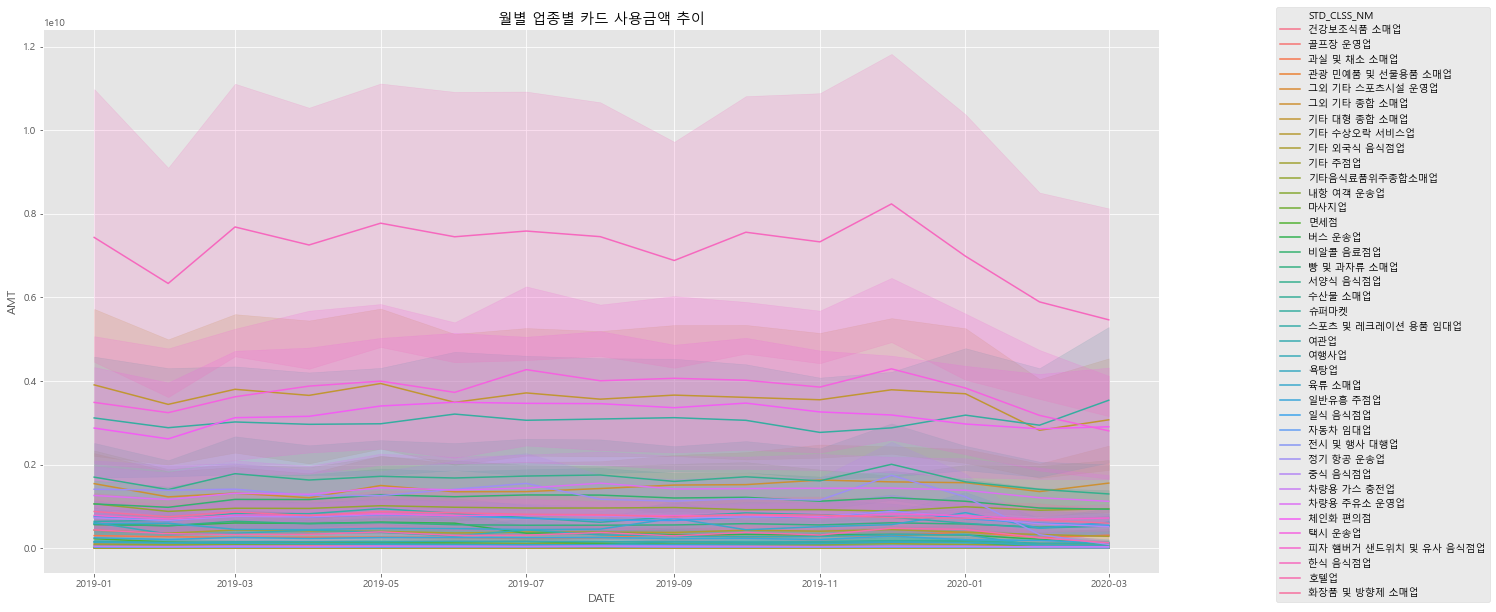

In [12]:
# plt.figure(figsize=(20,10))
# sns.lineplot(data=seoul, x='DATE', y='AMT', hue='STD_CLSS_NM')
# plt.legend(bbox_to_anchor=(1.1, 1.05))
# plt.title('월별 업종별 카드 사용금액 추이')

# 전월 대비 증감률 생성

In [12]:
seoul_1 = seoul.groupby(['REG_YYMM', 'STD_CLSS_NM'])['AMT', 'CNT'].sum().reset_index()

In [13]:
tmp = seoul_1.pivot_table(index='REG_YYMM', columns='STD_CLSS_NM', values='AMT', aggfunc='sum').apply(lambda x: x.diff() / x * 100).fillna(0)
stack_AMT_diff = tmp.stack().reset_index().rename(columns={0:'AMT_diff'})
stack_AMT_diff

,REG_YYMM,STD_CLSS_NM,AMT_diff
0,201901,건강보조식품 소매업,0.000000
1,201901,골프장 운영업,0.000000
2,201901,과실 및 채소 소매업,0.000000
3,201901,관광 민예품 및 선물용품 소매업,0.000000
4,201901,그외 기타 스포츠시설 운영업,0.000000
...,...,...,...
580,202003,택시 운송업,-13.242170
581,202003,피자 햄버거 샌드위치 및 유사 음식점업,4.692429
582,202003,한식 음식점업,-11.843996
583,202003,호텔업,-95.740420


In [14]:
tmp = seoul_1.pivot_table(index='REG_YYMM', columns='STD_CLSS_NM', values='CNT', aggfunc='sum').apply(lambda x: x.diff() / x * 100).fillna(0)
stack_CNT_diff = tmp.stack().reset_index().rename(columns={0:'CNT_diff'})
stack_CNT_diff

,REG_YYMM,STD_CLSS_NM,CNT_diff
0,201901,건강보조식품 소매업,0.000000
1,201901,골프장 운영업,0.000000
2,201901,과실 및 채소 소매업,0.000000
3,201901,관광 민예품 및 선물용품 소매업,0.000000
4,201901,그외 기타 스포츠시설 운영업,0.000000
...,...,...,...
580,202003,택시 운송업,-12.964278
581,202003,피자 햄버거 샌드위치 및 유사 음식점업,2.109133
582,202003,한식 음식점업,-9.592622
583,202003,호텔업,-39.421600


In [15]:
CLSS_df = pd.merge(stack_AMT_diff, stack_CNT_diff, on=['REG_YYMM', 'STD_CLSS_NM'])
CLSS_df = CLSS_df[CLSS_df['REG_YYMM'].isin([202003])].groupby(['STD_CLSS_NM'])['AMT_diff','CNT_diff'].sum()
CLSS_df

,AMT_diff,CNT_diff
STD_CLSS_NM,,
건강보조식품 소매업,11.121835,10.883847
골프장 운영업,46.433002,38.450570
과실 및 채소 소매업,18.137205,28.321786
관광 민예품 및 선물용품 소매업,-75.833473,-100.225225
그외 기타 스포츠시설 운영업,-106.397394,-166.473988
그외 기타 종합 소매업,9.674204,9.555282
기타 대형 종합 소매업,8.142938,5.456242
기타 수상오락 서비스업,14.284628,-0.757576
기타 외국식 음식점업,-15.043848,-13.931908


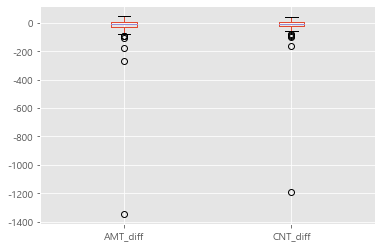

In [16]:
CLSS_df[['AMT_diff', 'CNT_diff']].boxplot()

# 군집분석

In [19]:
CLSS_df.reset_index(inplace=True)

In [20]:
cl_df = CLSS_df[['AMT_diff', 'CNT_diff']]
cl_df.tail()

,AMT_diff,CNT_diff
34,-13.242170,-12.964278
35,4.692429,2.109133
36,-11.843996,-9.592622
37,-95.740420,-39.421600
38,-12.336805,-15.909911


#### 표준화 및 역할 정의

In [21]:
X_list = list(cl_df.columns)
# 데이터 표준화
scaler = StandardScaler()
new_df_x = scaler.fit_transform(cl_df[X_list])

## k-평균 군집분석

#### 군집 개수 찾기 : 각 데이터로부터 가장 가까운 군집 중심점까지의 거리 제곱합


In [22]:
# 최대 군집 생성 개수
n_iter_cluster = 5
cluster_range = [i+1 for i in range(n_iter_cluster)]
clus_error = []
for v_n_clus in cluster_range : 
    clus = KMeans(v_n_clus)
    clus.fit(new_df_x)
    # 각 데이터로 부터 가장 가까운 군집 중심점까지 거리 제곱합
    clus_error.append(clus.inertia_)
ds_error = pd.DataFrame({'NumberofCluster' : cluster_range,
                        'Error' : clus_error})
ds_error

,NumberofCluster,Error
0,1,78.000000
1,2,4.573193
2,3,1.311167
3,4,0.783639
4,5,0.521440


#### 4-2) 군집별 군집 중시점까지 거리 제곱합 시각화

Text(0, 0.5, 'Sum of squared distance')

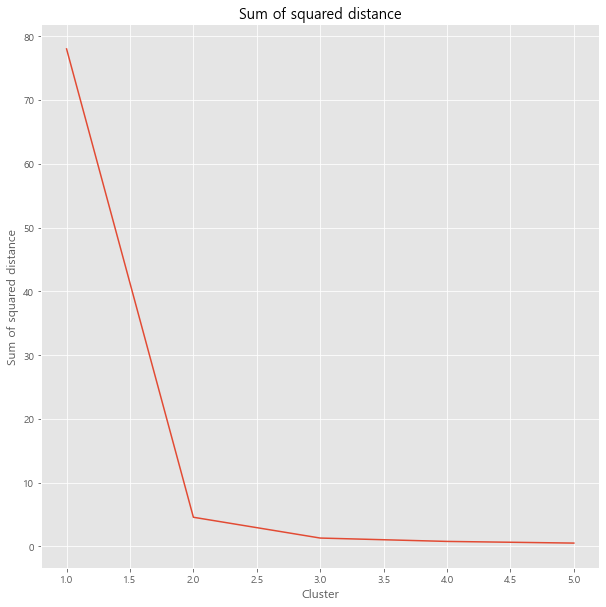

In [23]:
plt.figure(figsize = (10,10))
plt.plot(ds_error['NumberofCluster'], ds_error['Error'])
plt.title("Sum of squared distance")
plt.xlabel('Cluster')
plt.ylabel('Sum of squared distance')

#### 4-3) k-평균 군집 번호 생성

In [24]:
clus = KMeans(n_iter_cluster)
clus.fit(new_df_x)
cluster_kmeans = [i+1 for i in clus.labels_]
CLSS_df['ClusterKmeans'] = cluster_kmeans
CLSS_df.head()

,STD_CLSS_NM,AMT_diff,CNT_diff,ClusterKmeans
0,건강보조식품 소매업,11.121835,10.883847,1
1,골프장 운영업,46.433002,38.450570,1
2,과실 및 채소 소매업,18.137205,28.321786,1
3,관광 민예품 및 선물용품 소매업,-75.833473,-100.225225,3
4,그외 기타 스포츠시설 운영업,-106.397394,-166.473988,3


#### 4-4) k-평균 군집별 데이터 요약

In [25]:
ds_summary_km = CLSS_df.groupby("ClusterKmeans").agg(['min','mean','max'])
level0 = ds_summary_km.columns.get_level_values(0)
level1 = ds_summary_km.columns.get_level_values(1)
ds_summary_km.columns = level0 + '_' + level1
ds_summary_km.reset_index(inplace = True)
ds_summary_km.round(3)

,ClusterKmeans,AMT_diff_min,AMT_diff_mean,AMT_diff_max,CNT_diff_min,CNT_diff_mean,CNT_diff_max
0,1,3.780,13.269,46.433,-0.758,14.090,38.451
1,2,-1345.002,-1345.002,-1345.002,-1191.304,-1191.304,-1191.304
2,3,-106.397,-93.870,-75.833,-166.474,-94.069,-39.422
3,4,-265.373,-222.511,-179.650,-91.049,-73.770,-56.491
4,5,-46.942,-14.045,1.693,-44.626,-11.159,2.192


In [26]:
CLSS_df[CLSS_df['ClusterKmeans']==1].sort_values(by='AMT_diff',ascending=False)

,STD_CLSS_NM,AMT_diff,CNT_diff,ClusterKmeans
1,골프장 운영업,46.433002,38.450570,1
24,육류 소매업,22.353861,21.586843,1
2,과실 및 채소 소매업,18.137205,28.321786,1
7,기타 수상오락 서비스업,14.284628,-0.757576,1
19,슈퍼마켓,13.789914,12.865815,1
18,수산물 소매업,12.879824,25.982900,1
0,건강보조식품 소매업,11.121835,10.883847,1
5,그외 기타 종합 소매업,9.674204,9.555282,1
20,스포츠 및 레크레이션 용품 임대업,9.059804,12.806313,1
6,기타 대형 종합 소매업,8.142938,5.456242,1


In [27]:
CLSS_df[CLSS_df['ClusterKmeans']==2].sort_values(by='AMT_diff',ascending=False)

,STD_CLSS_NM,AMT_diff,CNT_diff,ClusterKmeans
13,면세점,-1345.00248,-1191.304348,2


In [28]:
CLSS_df[CLSS_df['ClusterKmeans']==3].sort_values(by='AMT_diff',ascending=False)

,STD_CLSS_NM,AMT_diff,CNT_diff,ClusterKmeans
3,관광 민예품 및 선물용품 소매업,-75.833473,-100.225225,3
14,버스 운송업,-95.329160,-80.236449,3
37,호텔업,-95.740420,-39.421600,3
28,전시 및 행사 대행업,-96.050610,-83.987342,3
4,그외 기타 스포츠시설 운영업,-106.397394,-166.473988,3


In [29]:
CLSS_df[CLSS_df['ClusterKmeans']==4].sort_values(by='AMT_diff',ascending=False)

,STD_CLSS_NM,AMT_diff,CNT_diff,ClusterKmeans
22,여행사업,-179.649630,-56.491416,4
29,정기 항공 운송업,-265.373027,-91.049031,4


In [30]:
CLSS_df[CLSS_df['ClusterKmeans']==5].sort_values(by='AMT_diff',ascending=False)

,STD_CLSS_NM,AMT_diff,CNT_diff,ClusterKmeans
33,체인화 편의점,1.692528,-1.350023,5
31,차량용 가스 충전업,-1.394537,0.444328,5
27,자동차 임대업,-2.568257,2.191558,5
15,비알콜 음료점업,-2.955621,-0.834553,5
32,차량용 주유소 운영업,-3.680233,1.359384,5
26,일식 음식점업,-9.205615,-7.145412,5
36,한식 음식점업,-11.843996,-9.592622,5
38,화장품 및 방향제 소매업,-12.336805,-15.909911,5
17,서양식 음식점업,-12.682254,-7.150754,5
34,택시 운송업,-13.242170,-12.964278,5


In [31]:
clss_dict = dict()
for i in range(n_iter_cluster):
    clss_dict[i] = list(CLSS_df[CLSS_df['ClusterKmeans']==i+1]['STD_CLSS_NM'].values)

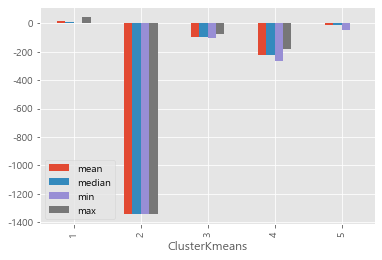

In [32]:
CLSS_df.groupby('ClusterKmeans')['AMT_diff'].agg(['mean','median', 'min', 'max']).plot(kind='bar')

In [33]:
cl1 = df[df['STD_CLSS_NM'].map(lambda x: x in clss_dict[0])]
cl2 = df[df['STD_CLSS_NM'].map(lambda x: x in clss_dict[1])]
cl3 = df[df['STD_CLSS_NM'].map(lambda x: x in clss_dict[2])]
cl4 = df[df['STD_CLSS_NM'].map(lambda x: x in clss_dict[3])]
cl5 = df[df['STD_CLSS_NM'].map(lambda x: x in clss_dict[4])]

In [34]:
cl1.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,CV
0,201901,서울,건강보조식품 소매업,20s,1,1,115,7809970,140,0
1,201901,서울,건강보조식품 소매업,20s,2,1,407,19074744,516,0
2,201901,서울,건강보조식품 소매업,20s,2,2,11,868200,12,0
3,201901,서울,건강보조식품 소매업,30s,1,1,10,4767250,11,0
4,201901,서울,건강보조식품 소매업,30s,1,2,874,74320644,1045,0


In [35]:
cl1.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,CV
0,201901,서울,건강보조식품 소매업,20s,1,1,115,7809970,140,0
1,201901,서울,건강보조식품 소매업,20s,2,1,407,19074744,516,0
2,201901,서울,건강보조식품 소매업,20s,2,2,11,868200,12,0
3,201901,서울,건강보조식품 소매업,30s,1,1,10,4767250,11,0
4,201901,서울,건강보조식품 소매업,30s,1,2,874,74320644,1045,0


In [36]:
cl1.to_csv('../Seoul/cl1.csv', index=False, encoding='utf-8-sig')
cl2.to_csv('../Seoul/cl2.csv', index=False, encoding='utf-8-sig')
cl3.to_csv('../Seoul/cl3.csv', index=False, encoding='utf-8-sig')
cl4.to_csv('../Seoul/cl4.csv', index=False, encoding='utf-8-sig')
cl5.to_csv('../Seoul/cl5.csv', index=False, encoding='utf-8-sig')